# Climate drivers

This notebook plots ENSO against surface area in a few different ways. Can we figure out which climate driver affects which waterbodies?

## Setup

### Load modules

In [2]:
pip install rioxarray

Unload all python modules, if you experience any issues.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 991 kB 4.4 MB/s eta 0:00:01
  Created wheel for rioxarray: filename=rioxarray-0.0.31-py3-none-any.whl size=39287 sha256=18c6e97898e1f47bc951dba01af7314ec3ca6190122c7d8348bcc6bb19bef61c
  Stored in directory: /home/547/ma6611/.cache/pip/wheels/d0/d8/f9/caa0e5b4936f60d2f2156c9092c3c7c4a3abd9c8163c22d2ec
Successfully built rioxarray
Note: you may need to restart the kernel to use updated packages.


In [3]:
import sys

import h5py
import cmocean.cm
import datacube
import geopandas as gpd
import matplotlib.animation
import matplotlib.colors
import matplotlib.patches
import numpy as np
import scipy.cluster
import scipy.ndimage.filters
import sklearn.cluster
import sklearn.decomposition
import sklearn.pipeline
import sklearn.preprocessing
import statsmodels.tsa.stattools
from matplotlib import pyplot as plt
from scipy import optimize as opt
from tqdm.notebook import tqdm
import pandas as pd
import xarray
import rasterio.mask
import rioxarray

sys.path.insert(1, "../Scripts")
import dea_plotting
import mattplot

%matplotlib inline

### Load the data

This was generated in LoadWaterbodies.ipynb.

In [6]:
waterbodies = gpd.read_file('waterbodies_joined_drainage_basins.shp').to_crs('EPSG:3577')

In [7]:
waterbodies = waterbodies.set_index('UID')

In [145]:
waterbodies.loc[pd.isnull(waterbodies.BNAME), 'BNAME'] = 'NONE'

In [5]:
history_file = h5py.File('interpolated_waterbodies_by_division_and_basin.h5', mode='r')

In [9]:
dates = pd.to_datetime([l.decode('ascii') for l in history_file['dates']])

Then load the SOI, AAO, and DMI data. You can download them from the NOAA:

In [10]:
%%bash
# wget https://stateoftheocean.osmc.noaa.gov/atm/data/soi.nc
# wget https://stateoftheocean.osmc.noaa.gov/sur/data/dmi.nc
# wget ftp://ftp.cpc.ncep.noaa.gov/cwlinks/norm.daily.aao.index.b790101.current.ascii

Unload all python modules, if you experience any issues.


Then read them in and convert to a daily time series.

In [154]:
soi = xarray.open_dataset('soi.nc').SOI
soi = pd.DataFrame({'SOI': soi.to_pandas()})
soi.index.name = 'Date'
soi = soi.resample('1D').mean().ffill()
soi = soi.reindex(dates)

In [155]:
dmi = xarray.open_dataarray('dmi.nc')
dmi = pd.DataFrame({'DMI': dmi.to_pandas()})
dmi.index.name = 'Date'
dmi = dmi.resample('1D').mean().ffill()
dmi = dmi.reindex(dates)

In [156]:
aao = pd.read_csv('norm.daily.aao.index.b790101.current.ascii', sep='\s+', names=['Year', 'Month', 'Day', 'AAO'], skiprows=[8885])
# 8885 has a bunch of asterisks instead of the AAO.
aao_dates = pd.to_datetime(aao[['Year', 'Month', 'Day']])
aao.index = aao_dates
aao.index = np.array(aao.index).astype('datetime64[D]')
aao = aao.resample('1D').mean().ffill()
aao = aao.reindex(dates)

## Calculate percentiles for El Nino, La Nina, etc.

For each time series, calculate the percentiles. We haven't filled the NaNs so we will just ignore them and compute the percentiles as if we have perfect observations. This should be equivalent to certain imputation methods (those based on percentiles, specifically...).

We assume that an absolute rolling monthly average $> 8$ indicates an ENSO phase, $> 0.4\circ\mathrm{C}$ indicates an IOD phase, and $> 0.5$ indicates a SAM phase.

The rolling window size is the indicative sustained time you need for a phase. For SAM this is about 4 weeks, and for ENSO it's a bit longer. I haven't found anything about the IOD! I assume it's much like ENSO.

In [158]:
rolling_aao = aao.AAO.rolling(28).mean()
rolling_soi = soi.SOI.rolling(28 * 4).mean() * 10
rolling_dmi = dmi.DMI.rolling(28 * 4).mean()

In [159]:
el_nino = rolling_soi < -7
la_nina = rolling_soi > 7
neutral_enso = ~el_nino & ~la_nina & pd.notnull(rolling_soi)

In [160]:
iod_neg = rolling_dmi < -0.4
iod_pos = rolling_dmi > 0.4
neutral_iod = ~iod_neg & ~iod_pos & pd.notnull(rolling_dmi)

In [161]:
sam_neg = rolling_aao < -0.5
sam_pos = rolling_aao > 0.5
neutral_sam = ~sam_neg & ~sam_pos & pd.notnull(rolling_aao)

In [162]:
phases = {
    'El Niño': el_nino,
    'La Niña': la_nina,
    'Neutral ENSO': neutral_enso,
    'Negative IOD': iod_neg,
    'Positive IOD': iod_pos,
    'Neutral IOD': neutral_iod,
    'Negative SAM': sam_neg,
    'Positive SAM': sam_pos,
    'Neutral SAM': neutral_sam,
}

In [163]:
colours = {
    'El Niño': 'red',
    'La Niña': 'blue',
    'Neutral ENSO': 'black',
    'Negative IOD': 'red',
    'Positive IOD': 'blue',
    'Neutral IOD': 'black',
    'Negative SAM': 'red',
    'Positive SAM': 'blue',
    'Neutral SAM': 'black',
}

Text(0.5, 1.0, 'ENSO events')

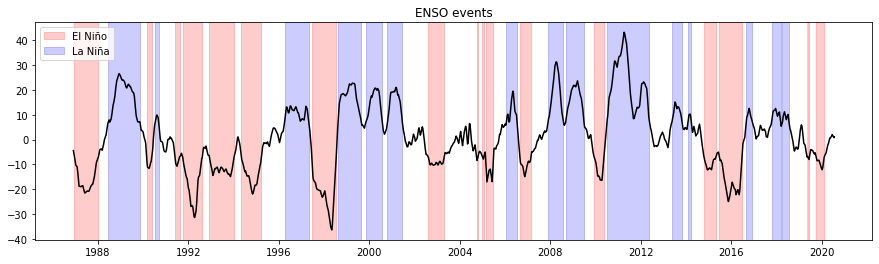

In [164]:
legend_handles = []
legend_names = []
plt.figure(figsize=(15, 4))
for name, mask in phases.items():
    if 'Ni' not in name:  # ENSO
        continue
    if 'Neutral' in name:
        continue
    # https://stackoverflow.com/questions/24281936/delimiting-contiguous-regions-with-values-above-a-certain-threshold-in-pandas-da
    # first row is a True preceded by a False
    fst = mask.index[mask & ~mask.shift(1).fillna(False)]
    # last row is a True followed by a False
    lst = mask.index[mask & ~mask.shift(-1).fillna(False)]
    for f, l in zip(fst, lst):
        v = plt.axvspan(f, l, alpha=0.2, color=colours[name])
    legend_handles.append(v)
    legend_names.append(name)
plt.legend(legend_handles, legend_names)
plt.plot(rolling_soi.index, rolling_soi, c='k')
plt.title('ENSO events')

This is in broad agreement [with the BOM](http://www.bom.gov.au/climate/about/australian-climate-influences.shtml?bookmark=enso).

Text(0.5, 1.0, 'IOD events')

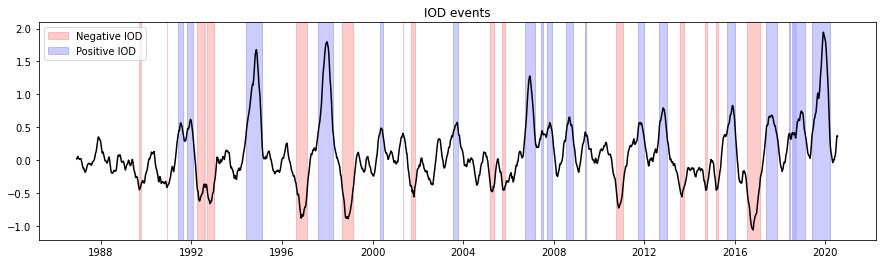

In [165]:
legend_handles = []
legend_names = []
plt.figure(figsize=(15, 4))
for name, mask in phases.items():
    if 'IOD' not in name:
        continue
    if 'Neutral' in name:
        continue
    fst = mask.index[mask & ~mask.shift(1).fillna(False)]
    lst = mask.index[mask & ~mask.shift(-1).fillna(False)]
    for f, l in zip(fst, lst):
        v = plt.axvspan(f, l, alpha=0.2, color=colours[name])
    legend_handles.append(v)
    legend_names.append(name)
plt.legend(legend_handles, legend_names)
plt.plot(rolling_dmi.index, rolling_dmi, c='k')
plt.title('IOD events')

In [166]:
for name, phase in phases.items():
    print(f'{name}: {sum(phase)} days')

El Niño: 3469 days
La Niña: 3814 days
Neutral ENSO: 4997 days
Negative IOD: 1255 days
Positive IOD: 2205 days
Neutral IOD: 8820 days
Negative SAM: 3093 days
Positive SAM: 4461 days
Neutral SAM: 4810 days


In [167]:
seasons = {
    'Summer': dates.month.isin({12, 1, 2}),
    'Autumn': dates.month.isin({3, 4, 5}),
    'Winter': dates.month.isin({6, 7, 8}),
    'Spring': dates.month.isin({9, 10, 11}),
}

In [168]:
waterbody_percentiles_seasonal = {season: {name: np.zeros((len(waterbodies), 10)) for name in phases} for season in seasons}

In [169]:
waterbody_percentiles_annual = {name: np.zeros((len(waterbodies), 10)) for name in phases}

In [176]:
for (div, basin), _ in tqdm(waterbodies.groupby(['Division_', 'BNAME'])):
    try:
        for name, mask in phases.items():
            for season, season_mask in seasons.items():
                percentiles = np.nanpercentile(history_file[div][basin]['pc_wet'][:, season_mask & mask.values], np.linspace(0, 100, 10), axis=1)
                waterbody_percentiles_seasonal[season][name][(waterbodies.Division_ == div) & (waterbodies.BNAME == basin)] = percentiles.T

            percentiles = np.nanpercentile(history_file[div][basin]['pc_wet'][:, mask.values], np.linspace(0, 100, 10), axis=1)
            waterbody_percentiles_annual[name][(waterbodies.Division_ == div) & (waterbodies.BNAME == basin)] = percentiles.T
    except KeyError:
        print('Couldn\'t find data for {}/{}'.format(div, basin))
        continue

Couldn't find data for Carpentaria Coast/NONE
Couldn't find data for Lake Eyre Basin/NONE
Couldn't find data for Murray-Darling Basin/NONE
Couldn't find data for North East Coast/NONE
Couldn't find data for North Western Plateau/NONE
Couldn't find data for Pilbara-Gascoyne/NONE
Couldn't find data for South Australian Gulf/NONE
Couldn't find data for South East Coast (NSW)/NONE
Couldn't find data for South East Coast (Victoria)/NONE
Couldn't find data for South West Coast/NONE
Couldn't find data for South Western Plateau/NONE
Couldn't find data for Tanami-Timor Sea Coast/NONE
Couldn't find data for Tasmania/NONE



In [191]:
import joblib
joblib.dump(waterbody_percentiles_seasonal, 'seasonal_waterbody_percentiles_10.joblib')
joblib.dump(waterbody_percentiles_annual, 'annual_waterbody_percentiles_10.joblib')
# waterbody_percentiles = joblib.load('seasonal_annual_waterbody_percentiles_10.joblib')

['annual_waterbody_percentiles_10.joblib']

## Deviation from neutral

Now measure the QQ deviation from neutral for El Nino and La Nina.

In [193]:
deviations_seasonal = {season: {} for season in waterbody_percentiles}
deviations_annual = {season: {} for season in waterbody_percentiles}

neutral_map = {
    'El Niño': 'Neutral ENSO',
    'La Niña': 'Neutral ENSO',
    'Negative IOD': 'Neutral IOD',
    'Positive IOD': 'Neutral IOD',
    'Negative SAM': 'Neutral SAM',
    'Positive SAM': 'Neutral SAM',
}

for season, wbps in waterbody_percentiles_seasonal.items():
    for name, percentiles in wbps.items():
        if 'Neutral' in name:
            continue
        # Percentiles is N x P.
        deviations_seasonal[season][name] = np.sqrt(((percentiles / 100 - wbps[neutral_map[name]] / 100) ** 2).mean(axis=1) / 2)

for name, percentiles in waterbody_percentiles_annual.items():
    if 'Neutral' in name:
        continue
    deviations_annual[name] = np.sqrt(((percentiles / 100 - waterbody_percentiles_annual[neutral_map[name]] / 100) ** 2).mean(axis=1) / 2)

In [218]:
deviations_seasonal['Annual'] = deviations_annual

In [243]:
# https://stackoverflow.com/a/61089196
deviation_df = pd.DataFrame(deviations_seasonal).stack().to_frame()
deviation_df = pd.DataFrame(deviation_df[0].values.tolist(), index=deviation_df.index).swaplevel()
deviation_df = deviation_df.sort_index()
deviation_df = deviation_df.T
deviation_df.index = waterbodies.index

In [245]:
deviation_df = deviation_df.join(waterbodies[['geometry', 'Division_', 'BNAME']])

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


Export the deviations at GeoJSON so we can load them into something.

In [253]:
for season in list(seasons) + ['Annual']:
    deviation_df[season, 'ENSO'] = np.sqrt(deviation_df[season, 'El Niño'] ** 2 + deviation_df[season, 'La Niña'] ** 2)
    deviation_df[season, 'IOD'] = np.sqrt(deviation_df[season, 'Positive IOD'] ** 2 + deviation_df[season, 'Negative IOD'] ** 2)
    deviation_df[season, 'SAM'] = np.sqrt(deviation_df[season, 'Positive SAM'] ** 2 + deviation_df[season, 'Negative SAM'] ** 2)

In [254]:
ascii_df = deviation_df.copy()
ascii_df.columns = [' '.join(column).replace('ñ', 'n') if isinstance(column, tuple) else column.replace('ñ', 'n') for column in deviation_df.columns]

In [255]:
ascii_df.columns = [c.replace('Autumn ', 'Aut').replace('Summer ', 'Sum').replace('Spring ', 'Spr').replace('Winter ', 'Win')\
                    .replace('El Nino', 'ElNino').replace('La Nina', 'LaNina').replace('Negative ', '-').replace('Positive ', '+')\
                    .replace(' deviation', 'Dev') for c in ascii_df.columns]

In [262]:
gpd.GeoDataFrame(ascii_df).to_file('climate_index_deviations.shp')

## Aggregate into basins

Merge all the basins together by taking the mean.

In [256]:
basin_deviations = ascii_df.groupby('BNAME').mean()

Then merge these with the geometries of the basins.

In [257]:
basins = gpd.read_file('river_basins_ga_1997_aggregated.geojson')

In [258]:
basin_deviations = basins.set_index('BNAME').join(basin_deviations)

In [261]:
basin_deviations

,fid,AREA,PERIMETER,AUS_,AUS_ID,F_CODE,BNUM,RNAME,RNUM,DNAME,...,AutSAM,WinENSO,WinIOD,WinSAM,SprENSO,SprIOD,SprSAM,Annual ENSO,Annual IOD,Annual SAM
BNAME,,,,,,,,,,,,,,,,,,,,,
ADELAIDE RIVER,1,0.621570,5.074124,95,94,dbasin_cent,17,DARWIN,F,TIMOR SEA,...,0.069369,0.108983,0.116300,0.073881,0.099767,0.085184,0.053174,0.089917,0.092842,0.043283
ALBANY COAST,2,1.917121,10.158938,1040,1072,dbasin_cent,2,ALBANY,B,SOUTH-WEST COAST,...,0.063275,0.122960,0.154855,0.077725,0.116966,0.129868,0.075804,0.076688,0.103720,0.036027
ARCHER RIVER,3,1.156676,6.761848,137,136,dbasin_cent,22,WEIPA,H,GULF OF CARPENTARIA,...,0.073914,0.094429,0.144525,0.066981,0.075132,0.075993,0.046950,0.068572,0.120823,0.052192
ARTHUR RIVER,4,0.268317,3.525179,1247,1279,dbasin_cent,12,GORDON,C,TASMANIA,...,0.062704,0.156620,0.163507,0.078952,0.106606,0.097984,0.056377,0.091722,0.103769,0.031508
ASHBURTON RIVER,5,6.684978,20.541601,777,779,dbasin_cent,6,PILBARA,D,INDIAN OCEAN,...,0.073561,0.102895,0.176993,0.073946,0.088370,0.090704,0.054605,0.106590,0.118280,0.055664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WISO,241,19.734627,27.233273,496,495,dbasin_cent,8,TENNANT,E,WESTERN PLATEAU,...,0.082418,0.143085,0.233350,0.081162,0.114411,0.108176,0.058651,0.097553,0.134599,0.050025
WOLLONGONG COAST,242,0.077403,2.510520,1075,1107,dbasin_cent,14,SYDNEY,C,SOUTH-EAST COAST,...,0.067998,0.122186,0.127069,0.069922,0.086115,0.101189,0.054539,0.070116,0.081408,0.035914
WOORAMEL RIVER,243,0.003708,0.557482,854,880,island_cent,3,MURCHISON-SHARK BAY,B,INDIAN OCEAN,...,0.074374,0.201591,0.138050,0.088203,0.129802,0.139150,0.054345,0.144037,0.099034,0.043484


In [260]:
gpd.GeoDataFrame(basin_deviations).to_file('climate_index_deviations_basins.shp')

And a colour scheme...

In [303]:
from scipy.spatial.transform import Rotation

In [328]:
def plot_legend():
    basis = np.array([[0.0, 1.0], [-1.5/np.sqrt(3), -0.5],[1.5/np.sqrt(3), -0.5]])

    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1, aspect='equal')
    ax2 = fig.add_subplot(1, 2, 2, aspect='equal')

    # Plot points
    a, b, c = np.mgrid[0.0:1.0:15j, 0.0:1.0:15j, 0.0:1.0:15j]
    a, b, c = a.flatten(), b.flatten(), c.flatten()
    abc = np.stack([a,b,c]).T
    data = np.dot(abc, basis)
    rgbs = np.stack([
        a,
        b,
        c,
    ]).T    
    mask = np.sum(rgbs, axis=1) >= 1
    ax1.scatter(data[:, 0], data[:, 1], c=rgbs[:])
#     rmat = Rotation.from_euler('x', 180, degrees=True).as_matrix()
    rmat = Rotation.from_euler('y', 180, degrees=True).as_matrix()
#     basis = rmat @ basis
#     data = np.dot(abc, basis)
    ax2.scatter(data[::-1, 0], data[::-1, 1], c=rgbs[::-1])
#     #abc = filter(lambda x: x[0]+x[1]+x[2]==1, abc) # remove points outside triangle
#     abc = [x/sum(x) for x in abc] # or just make sure points lie inside triangle ...

#     data = np.dot(abc, basis)
#     colours = [abc_to_rgb(A=point[0],B=point[1],C=point[2]) for point in abc]

#     ax.scatter(data[:,0], data[:,1],marker=',',edgecolors='none',facecolors=colours)

#     # Plot triangle
#     ax.plot([basis[_,0] for _ in range(3) + [0,]],[basis[_,1] for _ in range(3) + [0,]],**{'color':'black','linewidth':3})

#     # Plot labels at vertices
#     offset = 0.25
#     fontsize = 32
#     ax.text(basis[0,0]*(1+offset), basis[0,1]*(1+offset), '$A$', horizontalalignment='center',
#             verticalalignment='center', fontsize=fontsize)
#     ax.text(basis[1,0]*(1+offset), basis[1,1]*(1+offset), '$B$', horizontalalignment='center',
#             verticalalignment='center', fontsize=fontsize)
#     ax.text(basis[2,0]*(1+offset), basis[2,1]*(1+offset), '$C$', horizontalalignment='center',
#             verticalalignment='center', fontsize=fontsize)    

#     ax.set_frame_on(False)
#     ax.set_xticks(())
#     ax.set_yticks(())

#     plt.show()

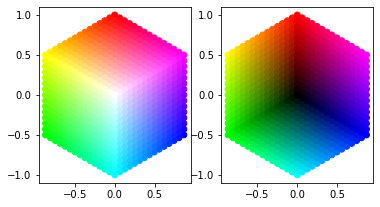

In [329]:
plot_legend()

Now let's plot these spatially. We'll rasterise everything.

In [57]:
centroids = waterbodies.centroid
xmin, xmax = centroids.x.min(), centroids.x.max()
ymin, ymax = centroids.y.min(), centroids.y.max()

In [58]:
xs = np.linspace(xmin, xmax, 1000)

In [59]:
ys = np.linspace(ymin, ymax, 1000)

In [61]:
X, Y = np.meshgrid(xs, ys)

In [65]:
ones = xarray.DataArray(np.ones((len(xs), len(ys))), coords={'x': xs, 'y': ys}, dims=['y', 'x'])

In [91]:
def transform_from_latlon(lat, lon):
    import affine
    # https://github.com/pydata/xarray/issues/501
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = affine.Affine.translation(lon[0], lat[0])
    scale = affine.Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

transform = transform_from_latlon(ys, xs)
out_shape = (len(ys), len(xs))

def get_mask(shape):
    return rasterio.features.rasterize([shape], out_shape=out_shape, fill=0, default_value=1, transform=transform, dtype=float, all_touched=True)

In [103]:
m2_per_px = (ys[1] - ys[0]) * (xs[1] - xs[0])

In [131]:
concerns = ['El Niño deviation', 'La Niña deviation',
       'Negative IOD deviation', 'Positive IOD deviation',
       'Negative SAM deviation', 'Positive SAM deviation', 'ENSO deviation',
       'IOD deviation', 'SAM deviation']

In [ ]:
total_weight = np.zeros(X.shape)
total_weighted_value = {col: np.zeros(X.shape) for col in deviation_df.columns}
total_value = {col: np.zeros(X.shape) for col in deviation_df.columns}
total_count = np.zeros(X.shape)

# gulf = deviation_df[deviation_df.Division__ == 'South Australian Gulf']
for uid, dfr in tqdm(deviation_df.iterrows(), total=len(deviation_df)):
    mask = get_mask(dfr.geometry)
    mask_area = mask.sum() * m2_per_px
    weight = waterbody.area / mask_area
    mask_ = mask > 0
    total_weight[mask_] += weight
    total_count[mask_] += 1
    for col in concerns:
        total_weighted_value[col][mask_] += dfr[col]
        total_value[col][mask_] += weight * dfr[col]

In [190]:
rgb = np.stack([total_value[c] / total_weight for c in ['ENSO deviation', 'SAM deviation', 'IOD deviation']]).transpose((1, 2, 0))
rgb[np.isnan(rgb)] = 0
rgb = np.log(rgb + 1)
rgb /= rgb.max()
R, G, B = rgb.transpose(2, 0, 1)

fig, ((a, b), (c, d)) = plt.subplots(2, 2, figsize=(10, 10))
a.imshow(R, origin='lower', cmap='Greys_r', vmin=0, vmax=1)
a.set_title('ENSO')
b.imshow(G, origin='lower', cmap='Greys_r', vmin=0, vmax=1)
b.set_title('SAM')
c.imshow(B, origin='lower', cmap='Greys_r', vmin=0, vmax=1)
c.set_title('IOD')
d.imshow(rgb, origin='lower')

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [72]:
out_image, out_transform = rasterio.mask.mask(ones.rio, waterbodies.geometry[0], crop=False)

AttributeError: 'function' object has no attribute 'e'

## Spatial autocorrelation

One sanity check that might also prove interesting is the spatial autocorrelation of the influence of El Nino and La Nina on waterbodies. This is kinda tricky to calculate, but we can start with a KDTree to make queries much faster.

In [134]:
import sklearn.neighbors

In [135]:
points = np.stack([waterbodies.centroid.x, waterbodies.centroid.y]).T

In [136]:
kd = sklearn.neighbors.KDTree(points)

For each point, we now need to find all points within a certain distance.

Then compute the Moran I statistic:

$$
I = \frac N W \frac {\sum_i \sum_j w_{ij}(x_i-\bar x) (x_j-\bar x)} {\sum_i (x_i-\bar x)^2}
$$

$w_{ij} = 1$ for neighbours and $0$ otherwise  ($w_{ii} = 0$). $W$ is the total number of neighbours i.e. the sum of $w$. $N$ is the number of waterbodies.  $\overline x$ is the mean over the whole dataset &mdash; this seems odd to me but I guess the weights figure it out somehow.

In [154]:
def moran_I(radius):
    # radius in metres since that's the units of the Australian Albers coordinates.
    query = kd.query_radius(points, r=radius)

    numerator = 0
    denominator = 0
    W = 0
    N = 0

    mean_end = np.nanmean(end)

    for i, js in enumerate(query):
        if len(js) <= 1:
            continue

        if np.isnan(end[i]):
            continue

        N += 1
        js = js[(js != i) & ~np.isnan(end[js])]
        W += len(js)
        numerator += sum((end[i] - mean_end) * (end[js] - mean_end))
        denominator += (end[i] - mean_end) ** 2
    return N / W * numerator / denominator

In [158]:
radii = np.linspace(100, 10000, 10)
moran_Is = [moran_I(r) for r in tqdm(radii)]

In [160]:
plt.figure()
plt.plot(radii, moran_Is)
plt.xlabel('Radius (m)')
plt.ylabel('Moran I')

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, 'Moran I')

Unsurprisingly correlation decreases as you get further away, and nearby waterbodies are highly correlated. We can see this in more detail with a local Moran I index:

$$
    I_i = \frac{x_i - \overline x}{\sigma_i^2} \sum_{j = 1, j \neq i}^N w_{ij} (x_j - \overline x)
$$
with
$$
    \sigma_i^2 = \frac{1}{N - 1} \sum_{j = 1, j \neq i}^N (x_j - \overline x)^2.
$$

In [188]:
def local_moran_I(radius: 'm'):
    query = kd.query_radius(points, r=radius)

    morans = []
    mean_end = np.nanmean(end)
    idxs = np.arange(len(end))

    # Calculate the Si values.
    diffs = end - mean_end
    sq_diffs = (end - mean_end) ** 2
    nan_mask = ~np.isnan(end)
    n_not_nan = sum(nan_mask)
    sum_sq_diffs = sum(sq_diffs[nan_mask]) / n_not_nan
    
    for i, js in enumerate(tqdm(query)):
        if len(js) <= 1:
            morans.append(0)
            continue

        if np.isnan(end[i]):
            morans.append(0)
            continue

        js = js[(js != i) & ~np.isnan(end[js])]
        
        xi = end[i]
        diff_xi = diffs[i]
        diff_xj = diffs[js]
        si2 = sum_sq_diffs - diff_xi ** 2 / n_not_nan
        I = diff_xi / si2 * diff_xj.sum()
        morans.append(I)
    return morans

In [189]:
local_morans = local_moran_I(1000)

In [ ]:
division = 'North East Coast'
wbs = waterbodies[waterbodies.Division__ == division]
el_nino_average = mattplot.spatial_average(wbs.centroid.x, wbs.centroid.y, end[waterbodies.Division__ == division])

In [209]:
da = xarray.DataArray(el_nino_average, coords={'x': xcoords, 'y': ycoords}, dims=['y', 'x'])
da.to_netcdf('ne_coast_endeviation.nc')

In [190]:
local_moran_average = mattplot.spatial_average(wbs.centroid.x, wbs.centroid.y, np.array(local_morans)[waterbodies.Division__ == division], progress=tqdm)

../Scripts/mattplot.py:26: RuntimeWarning: invalid value encountered in true_divide
  return total / count


In [197]:
xcoords = np.linspace(wbs.centroid.x.min(), wbs.centroid.x.max(), 500)
ycoords = np.linspace(wbs.centroid.y.min(), wbs.centroid.y.max(), 500)

In [206]:
da = xarray.DataArray(local_moran_average, coords={'x': xcoords, 'y': ycoords}, dims=['y', 'x'])

In [207]:
plt.figure()
da.plot.imshow()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [208]:
da.to_netcdf('ne_coast_moran.nc')